In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchinfo import summary
import os
from transformers import BertTokenizer, BertModel
import pandas as pd

import gc
import pickle

from sklearn import metrics

In [2]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
model= torch.load("./resnet152.pth")
model= model.to(device)

In [4]:
class ImageEncoder(nn.Module):
    def __init__(self, output_dim):
        super(ImageEncoder, self).__init__()
        self.ResNet= models.resnet152(pretrained=True) 
        self.ResNet.fc= nn.Linear(self.ResNet.fc.in_features, output_dim)
        self.relu= nn.ReLU()
        self.dropout= nn.Dropout(0.5)
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])
    
    def forward(self, x):
        features= self.ResNet(torch.stack([self.preprocess(img) for img in x]))
        return self.dropout(self.relu(features))

In [5]:
class TextEncoder(nn.Module):
    def __init__(self, max_pad):
        super(TextEncoder, self).__init__()
        self.max_pad= max_pad
        self.tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert= BertModel.from_pretrained("bert-base-uncased")
    
    def encode_sentence(self, text):
        vals=[]
        for sentence in text:
            vals.append(['[CLS]']+self.tokenizer.tokenize(sentence)+['[SEP]'])
        
        token_ids = []
        attention_masks = []
        for val in vals:
            pad_count= self.max_pad-len(val)
            attention_masks.append([1]*len(val)+[0]*pad_count)
            if(len(val)!=self.max_pad):
                val.extend(['[PAD]']*pad_count) 
        
            token_ids.append(self.tokenizer.convert_tokens_to_ids(val))
        
        token_ids= torch.tensor(token_ids)
        attention_masks= torch.tensor(attention_masks)
        
        return token_ids, attention_masks
    
    def forward(self, x):
        token_ids, attention_masks = self.encode_sentence(x)
        outputs = self.bert(token_ids, attention_mask=attention_masks)
        sentence_embedding = outputs[1]        
        return sentence_embedding


In [6]:
main_df= pd.read_pickle("../outputs/caption_description.pkl")
main_df

,label,text,file,description,sets
0,0,berserk 2016 is a good adaptation you're kidd...,71094.png,woman with a monkey mask and a fake monkey,[test_unseen]
1,0,my life goal? make somebody this fucking trig...,91724.png,woman holding a cigarette in her hand,[train]
2,0,""" i don't wanna, just get it, get it, get it, ...",64280.png,man wearing a hat and a tie,[train]
3,0,"""1st day of 4th grade sandy hook elementary sc...",67082.png,group of children standing in front of a schoo...,"[dev_seen, dev_unseen]"
4,0,"""a blow job a day will keep his side chicks aw...",46380.png,woman with a black top and a blue background,[train]
...,...,...,...,...,...
12135,1,your post is under coon review and it ain't lo...,59482.png,man speaking into a microphone,[test_unseen]
12136,1,your purchase of $19.99 comes to $21.36 after ...,21693.png,man in a kitchen with a calculator,[train]
12137,1,your purchase of $19.99 comes to $21.36 after ...,59837.png,man in a kitchen with a calculator,[train]
12138,1,"your sense of humor is so dark, police want to...",42897.png,man talking into a microphone,[train]


In [7]:
train_set= main_df[["train" in arr for arr in main_df["sets"]]]
train_set

,label,text,file,description,sets
1,0,my life goal? make somebody this fucking trig...,91724.png,woman holding a cigarette in her hand,[train]
2,0,""" i don't wanna, just get it, get it, get it, ...",64280.png,man wearing a hat and a tie,[train]
4,0,"""a blow job a day will keep his side chicks aw...",46380.png,woman with a black top and a blue background,[train]
5,0,"""a wiggle never hurt anybody."" dorothy donegan...",97832.png,piano and a piano keyboard,[train]
6,0,"""a wiggle never hurt anybody."" dorothy donegan...",95034.png,person playing a piano and a tombstone,[train]
...,...,...,...,...,...
12131,1,your milkshake brings all the tards to the yard,18296.png,group of people with surfboards,[train]
12132,1,your new name is abdul you'll take it and like...,95263.png,person holding a pencil and a chain,[train]
12136,1,your purchase of $19.99 comes to $21.36 after ...,21693.png,man in a kitchen with a calculator,[train]
12137,1,your purchase of $19.99 comes to $21.36 after ...,59837.png,man in a kitchen with a calculator,[train]


In [8]:
batch_size=16
num_batches= int(np.ceil(len(train_set)/batch_size))
text_encoder= TextEncoder(90)
image_encoder= ImageEncoder(768)
print(num_batches)

c:\Users\deban\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deban\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


532


In [9]:
# maxnum= len(train_set)
# for i in range(0, num_batches):
#     print(i)
#     minval = i*batch_size
#     maxval= min((i+1)*batch_size, maxnum)
    
#     text_arr= list(train_set[minval:maxval]["text"])    
#     with open(f"./temps/{i}_txt_out.pkl", "wb") as f:    
#         pickle.dump(text_encoder(text_arr), f) 
#     del text_arr
    
#     img_temp=[]
#     for file in train_set[minval:maxval]["file"]:
#         full_path=f"../../hateful_memes/img/{file}"
#         pil_img= Image.open(full_path)
#         pil_img= pil_img.convert("RGB")
#         img_temp.append(pil_img)
#     with open(f"./temps/{i}_img_out.pkl", "wb") as f:    
#         pickle.dump(image_encoder(img_temp), f)
#     del img_temp
    
#     gc.collect()

In [10]:
map=[]
labels=[]
image_encodings=[]
text_encodings=[]
maxnum= len(train_set)

for file in os.listdir("./temps"):
    
    num= int(file.split("_")[0])
    
    if num not in map:
        minval = num*batch_size
        maxval= min((num+1)*batch_size, maxnum)
        map.append(num)
        arr= list(train_set["label"][minval:maxval])
        labels.extend(arr)
        
    type= file.split("_")[1]

    with open(f"./temps/{file}", "rb") as f:
        val_arr= pickle.load(f)
    if(type=="img"):
        image_encodings.extend(val_arr)
    elif(type=="txt"):
        text_encodings.extend(val_arr)

In [11]:
for i in range(maxnum):
    image_encodings[i]= image_encodings[i].detach().numpy()
    text_encodings[i]= text_encodings[i].detach().numpy()
image_encodings= np.array(image_encodings)
text_encodings= np.array(text_encodings)

In [12]:
final_dset_train= np.concatenate([image_encodings.reshape(len(image_encodings), 1, -1), 
                                  text_encodings.reshape(len(text_encodings), 1, -1)], axis=2)

In [13]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return sample

In [14]:
train_set= MyDataset(final_dset_train, labels)

In [15]:
test_set= main_df[["train" not in val for val in main_df["sets"]]]

In [16]:
#using exact same procedure as above, pickle files are generated for all the test datasets
map=[]
labels2=[]
image_encodings2=[]
text_encodings2=[]
maxnum= len(test_set)

for file in os.listdir("./temps2"):
    
    num= int(file.split("_")[0])
    
    if num not in map:
        minval = num*batch_size
        maxval= min((num+1)*batch_size, maxnum)
        map.append(num)
        arr= list(test_set["label"][minval:maxval])
        labels2.extend(arr)
        
    type= file.split("_")[1]

    with open(f"./temps2/{file}", "rb") as f:
        val_arr= pickle.load(f)
    if(type=="img"):
        image_encodings2.extend(val_arr)
    elif(type=="txt"):
        text_encodings2.extend(val_arr)
        
for i in range(maxnum):
    image_encodings2[i]= image_encodings2[i].detach().numpy()
    text_encodings2[i]= text_encodings2[i].detach().numpy()
image_encodings2= np.array(image_encodings2)
text_encodings2= np.array(text_encodings2)

In [17]:
final_dset_test= np.concatenate([image_encodings2.reshape(len(image_encodings2), 1, -1), 
                                  text_encodings2.reshape(len(text_encodings2), 1, -1)], axis=2)
test_set= MyDataset(final_dset_test, labels2)

In [18]:
train_loader= DataLoader(train_set, 16, shuffle=True)
test_loader= DataLoader(test_set, 16, shuffle=True)
train_loader2= DataLoader(train_set, 32, shuffle=True)
test_loader2= DataLoader(test_set, 32, shuffle=True)

In [19]:
torch.manual_seed(43)
np.random.seed(43)

class RNNmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super(RNNmodel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers= num_layers
        self.layer_norm = nn.LayerNorm(hidden_dim)
        # self.dropout= nn.Dropout(dropout)
        
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) 
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        out, _ = self.rnn(x, hidden)
        out = out[:, -1, :]
        # out= self.dropout(out)
        out = self.fc(out)
        return out
    
model = RNNmodel(1536, 128, 2, 3)
lr= 5e-05
num_epoch= 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

In [20]:
train_loss=[]
test_loss=[]

for epoch in range(1, num_epoch+1):
    total_loss = 0
    for batch in train_loader:
        X= batch["data"]
        y= batch["label"]
        optimizer.zero_grad() 
        X = X.float()
        output = model(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()    
        
    total_test_loss=0
    total_acc= 0

    with torch.no_grad():  # Disable gradient calculation during testing
        for batch in test_loader:
            X_test = batch["data"]
            y_test = batch["label"]
            X_test = X_test.float()
            output_test = model(X_test)
            loss_test = criterion(output_test, y_test)
            
            total_acc+= metrics.accuracy_score((torch.max(output_test, dim=1)[1]).detach().numpy(), y_test)
            total_test_loss += loss_test.item()
            
    total_test_loss /= len(test_loader)
    total_acc /= len(test_loader)
    total_loss /= len(train_loader)
    
    train_loss.append(total_loss)
    test_loss.append(total_test_loss)
    
    # Print training and testing loss
    print('Epoch: {}/{} - Train Loss: {:.4f} - Test Loss: {:.4f} - Test Accuracy: {:.4f}'.format(epoch, num_epoch, total_loss, total_test_loss, total_acc))


Epoch: 1/50 - Train Loss: 0.6963 - Test Loss: 0.6888 - Test Accuracy: 0.5524
Epoch: 2/50 - Train Loss: 0.6714 - Test Loss: 0.6802 - Test Accuracy: 0.5896
Epoch: 3/50 - Train Loss: 0.6593 - Test Loss: 0.6777 - Test Accuracy: 0.5918
Epoch: 4/50 - Train Loss: 0.6534 - Test Loss: 0.6775 - Test Accuracy: 0.5913
Epoch: 5/50 - Train Loss: 0.6504 - Test Loss: 0.6780 - Test Accuracy: 0.5913
Epoch: 6/50 - Train Loss: 0.6484 - Test Loss: 0.6785 - Test Accuracy: 0.5916
Epoch: 7/50 - Train Loss: 0.6473 - Test Loss: 0.6792 - Test Accuracy: 0.5913
Epoch: 8/50 - Train Loss: 0.6466 - Test Loss: 0.6799 - Test Accuracy: 0.5910
Epoch: 9/50 - Train Loss: 0.6461 - Test Loss: 0.6798 - Test Accuracy: 0.5918
Epoch: 10/50 - Train Loss: 0.6457 - Test Loss: 0.6805 - Test Accuracy: 0.5913
Epoch: 11/50 - Train Loss: 0.6456 - Test Loss: 0.6804 - Test Accuracy: 0.5916
Epoch: 12/50 - Train Loss: 0.6451 - Test Loss: 0.6811 - Test Accuracy: 0.5907
Epoch: 13/50 - Train Loss: 0.6448 - Test Loss: 0.6811 - Test Accuracy: 0.

In [21]:
y_pred= model(torch.tensor(final_dset_test).float()).reshape(len(labels2), 2)
auroc= metrics.roc_auc_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels2)
rec= metrics.recall_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels2)
auroc, rec

(0.6007260400764506, 0.6086956521739131)

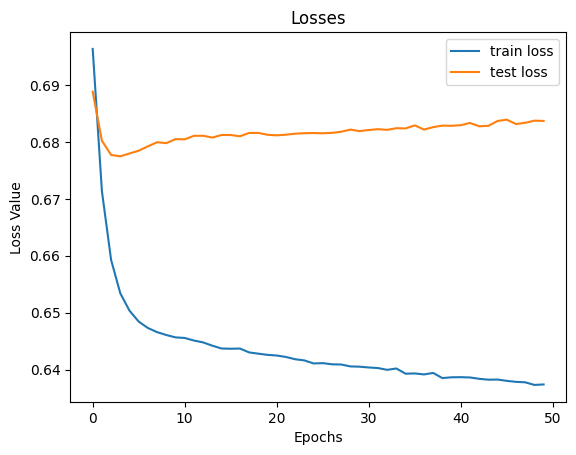

In [22]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(test_loss)), test_loss, label="test loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

self.model= nn.Sequential(
            nn.Linear(1536, 1024),
            nn.Dropout(0.9),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(512, 216),
            nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(216, 128),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(128, 2),
        )
        0.48, 0.59, curve good 


        def __init__(self):
        super(MLPModel, self).__init__()
        self.model= nn.Sequential(
            nn.Linear(1536, 1024),
            nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Dropout(0.5),
            nn.ReLU(),
        )
        lr= 1e-5
        (0.5041679022108003, 0.5697802197802198)


nn.Linear(1536, 1024),
            nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Dropout(0.7),
            nn.ReLU(),
(0.5250737463126843, 0.5909340659340659) mom=0.5 w or wo


self.model= nn.Sequential(
            nn.Linear(1536, 1024),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Dropout(0.3),
            nn.ReLU(),
        )
        lr-2-3-4-5
(0.5459690778575372, 0.5914835164835165) -4 443 better curve, 333 sharp curves but (61) 555 (0.5619110310421286, 0.592032967032967)
(0.5105111959752182, 0.5722527472527472) -5
(0.5815235179730068, 0.5936813186813187) -3

80 epochs, pretty jagged

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.model= nn.Sequential(
            nn.Linear(1536, 1000),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(500, 2),
            nn.Dropout(0.4),
            nn.ReLU(),
        )
            
    def forward(self, x):
        return self.model(x)
    
model2 = MLPModel()
lr= 1e-5
(0.512958191047068, 0.5873626373626374)

self.model= nn.Sequential(
            nn.Linear(1536, 1024),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 216),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(216, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
1e-5 (0.5457669048927982, 0.5914835164835165)

In [23]:
torch.manual_seed(43)
np.random.seed(43)

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.model= nn.Sequential(
            nn.Linear(1536, 1024),
            nn.Dropout(0.35),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.35),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Dropout(0.35),
            nn.ReLU()
        )
            
    def forward(self, x):
        return self.model(x)
    
model2 = MLPModel()
lr= 1e-4
num_epoch= 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)

In [24]:
train_loss=[]
test_loss=[]

for epoch in range(1, num_epoch+1):
    total_loss = 0
    for batch in train_loader2:
        X= batch["data"]
        y= batch["label"]
        optimizer.zero_grad() 
        X = X.float()
        output = model2(X).reshape(len(y), 2)
        loss = criterion(output, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    total_test_loss=0
    total_acc= 0

    with torch.no_grad():  # Disable gradient calculation during testing
        for batch in test_loader2:
            X_test = batch["data"]
            y_test = batch["label"]
            X_test = X_test.float()
            output_test = model2(X_test).reshape(len(y_test), 2)
            loss_test = criterion(output_test, y_test)
            
            total_acc+= metrics.accuracy_score((torch.max(output_test, dim=1)[1]).detach().numpy(), y_test)
            total_test_loss += loss_test.item()
            
    total_test_loss /= len(test_loader)
    total_acc /= len(test_loader)
    total_loss /= len(train_loader)
    
    train_loss.append(total_loss)
    test_loss.append(total_test_loss)
    
    # Print training and testing loss
    print('Epoch: {}/{} - Train Loss: {:.4f} - Test Loss: {:.4f} - Test Accuracy: {:.4f}'.format(epoch, num_epoch, total_loss, total_test_loss, total_acc))

Epoch: 1/50 - Train Loss: 0.3509 - Test Loss: 0.3488 - Test Accuracy: 0.2537
Epoch: 2/50 - Train Loss: 0.3487 - Test Loss: 0.3478 - Test Accuracy: 0.2661
Epoch: 3/50 - Train Loss: 0.3477 - Test Loss: 0.3473 - Test Accuracy: 0.2727
Epoch: 4/50 - Train Loss: 0.3470 - Test Loss: 0.3468 - Test Accuracy: 0.2812
Epoch: 5/50 - Train Loss: 0.3468 - Test Loss: 0.3467 - Test Accuracy: 0.2824
Epoch: 6/50 - Train Loss: 0.3466 - Test Loss: 0.3465 - Test Accuracy: 0.2871
Epoch: 7/50 - Train Loss: 0.3464 - Test Loss: 0.3464 - Test Accuracy: 0.2876
Epoch: 8/50 - Train Loss: 0.3462 - Test Loss: 0.3462 - Test Accuracy: 0.2892
Epoch: 9/50 - Train Loss: 0.3463 - Test Loss: 0.3460 - Test Accuracy: 0.2872
Epoch: 10/50 - Train Loss: 0.3454 - Test Loss: 0.3454 - Test Accuracy: 0.2939
Epoch: 11/50 - Train Loss: 0.3447 - Test Loss: 0.3452 - Test Accuracy: 0.2910
Epoch: 12/50 - Train Loss: 0.3438 - Test Loss: 0.3445 - Test Accuracy: 0.2926
Epoch: 13/50 - Train Loss: 0.3418 - Test Loss: 0.3431 - Test Accuracy: 0.

In [25]:
y_pred= model2(torch.tensor(final_dset_test).float()).reshape(len(labels2), 2)
auroc= metrics.roc_auc_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels2)
acc= metrics.accuracy_score((torch.max(y_pred, dim=1)[1]).detach().numpy(), labels2)
auroc, acc

(0.4720819600266272, 0.5901098901098901)

In [26]:
y_pred

tensor([[0.6959, 0.0000],
        [0.5059, 0.0000],
        [0.0000, 0.0000],
        ...,
        [0.7316, 0.0000],
        [0.5712, 0.0000],
        [0.0000, 0.0000]], grad_fn=<ViewBackward0>)

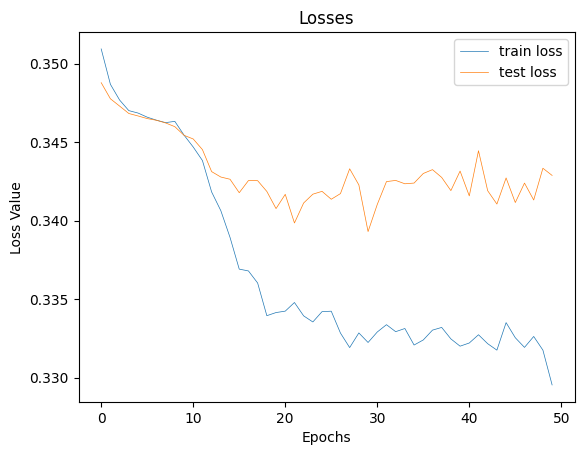

In [27]:
plt.plot(range(len(train_loss)), train_loss, label="train loss", linewidth=0.5)
plt.plot(range(len(test_loss)), test_loss, label="test loss", linewidth=0.5)
plt.legend()
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()